# Compare obs/reanalyses/models to Climate Indices
- **AMO** (SST from HadISST and OISST)
- **ENSO** (SST from HadISST and OISST)

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress
import xesmf as xe
from eofs.xarray import Eof as eof
import xeofs

In [2]:
#load in AMO Index (original and oisst)
amo_had_ds = xr.open_dataset('/work5/stb/MHW-gfdl/compare_avgs_trends/amo_index.nc', chunks={})
amo_had = amo_had_ds.sst

amo_oi_ds = xr.open_dataset('/work5/stb/MHW-gfdl/compare_avgs_trends/detrended-oisst-anom.nc', chunks={})
amo_oi = amo_oi_ds.oisst

nino_ds = xr.open_dataset('/work5/stb/MHW-gfdl/compare_avgs_trends/nino34_long_anom.nc', chunks={})
nino34 = nino_ds.value.sel(time=slice('1983', '2020'))

## Load in data & Compute linear trend

In [3]:
#(dir: `/work/c1f/data/AM5_Inputs/downloads/`)
hadisst_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/HadISST_sst.nc', chunks={})
pcmdi_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc',
                           chunks={})
#https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html
oisst_ds = xr.open_dataset('sst.mon.mean.nc', chunks={})

time_slice83 = dict(time=slice('1983', '2021-06-30'))

gom_h = dict(latitude=slice(31.5, 17.5), longitude=slice(-99,-80), )
gom_o = dict(lat=slice(17.5,31.15), lon=slice(261,279.5))

hadisst83 = hadisst_ds.sst.sel(**gom_h).sel(**time_slice83)
oisst83 = oisst_ds.sst.sel(**gom_o).sel(**time_slice83)

In [4]:
era = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc', chunks={})
glorys = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/Glorys/sst.nc', chunks={})
esm4_ocean = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ESM4/ds_ocean.nc', chunks={})
esm4_atm = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ESM4/ds_atm_new.nc', chunks={})

In [5]:
datetimeindex = esm4_ocean.indexes['time'].to_datetimeindex(time_unit='ns')
esm4_ocean['time'] = datetimeindex
esm4_atm['time'] = datetimeindex

/vftmp/Shanice.Bailey/pid461125/ipykernel_901803/3799942295.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = esm4_ocean.indexes['time'].to_datetimeindex(time_unit='ns')


## Calculate trend lines

In [7]:
def trending_basin(da, da_name, coord_name=None):
    
    d = {}
    d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean([da.dims[1], da.dims[2]]))
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])
    return d

In [8]:
#obs 
trend_dict_hadisst83 = trending_basin(hadisst83, hadisst83.name)                 
trend_dict_oisst83 = trending_basin(oisst83, oisst83.name)

#reanlyses
trend_dict_sst_era83 = trending_basin(era.sst, era.sst.name)
trend_dict_sst_esm483 = trending_basin(esm4_ocean.tos, esm4_ocean.tos.name)
trend_dict_sst_glorys = trending_basin(glorys.thetao, glorys.thetao.name)

In [10]:
trend_line_sst83 = [trend_dict_hadisst83['sst_trend_line_lr'],
                    trend_dict_oisst83['sst_trend_line_lr'], 
                    trend_dict_sst_era83['sst_trend_line_lr'],
                    trend_dict_sst_esm483['tos_trend_line_lr'], 
                    trend_dict_sst_glorys['thetao_trend_line_lr']]
names = ['hadisst83', 'oisst83', 'era_sst83', 'esm483', 'glorys']
print("\033[1m SST Trend slopes w intercepts (1983-2021)\033[0m")
for (i,j) in zip(names, trend_line_sst83):
    print(i, ':', j[:3], '...')

 SST Trend slopes w intercepts (1983-2021)
hadisst83 : [26.18406989 26.18504292 26.18601594] ...
oisst83 : [25.91158649 25.91338581 25.91518513] ...
era_sst83 : [25.9483801  25.94843925 25.94849841] ...
esm483 : [26.25383246 26.25387573 26.253919  ] ...
glorys : [26.28402947 26.2840784  26.28412733] ...


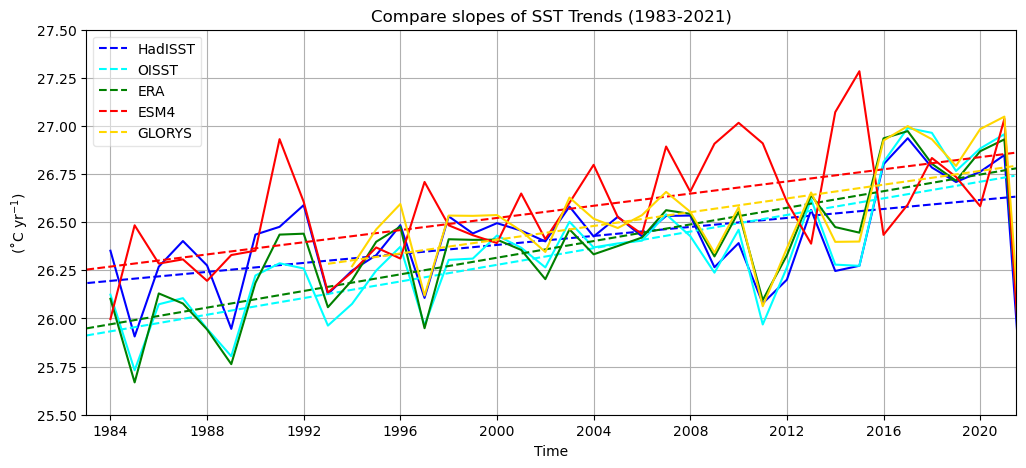

In [11]:
da_names = [hadisst83, oisst83, era.sst, esm4_ocean.tos, glorys.thetao]
var_titles = ['HadISST', 'OISST', 'ERA', 'ESM4', 'GLORYS']
line_colors = ['blue', 'cyan', 'green', 'red', 'gold']
plt.figure(figsize=(12,5))
for i in np.arange(0,5):
    plt.plot(da_names[i].time, trend_line_sst83[i], 
             label=f'{var_titles[i]}', color=line_colors[i],
             linestyle='dashed')
    da_names[i].mean([da_names[i].dims[1], 
                      da_names[i].dims[2]]).resample(time='1YE').mean().plot(color=line_colors[i])
plt.ylabel(r'(˚C yr$^{-1}$)')
plt.xlim(era.time.sel(time='1983-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.ylim(25.5, 27.5)
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SST Trends (1983-2021)');
#plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/slopes_sst.pdf');

# Compare to AMO & Nino 3.4 Index

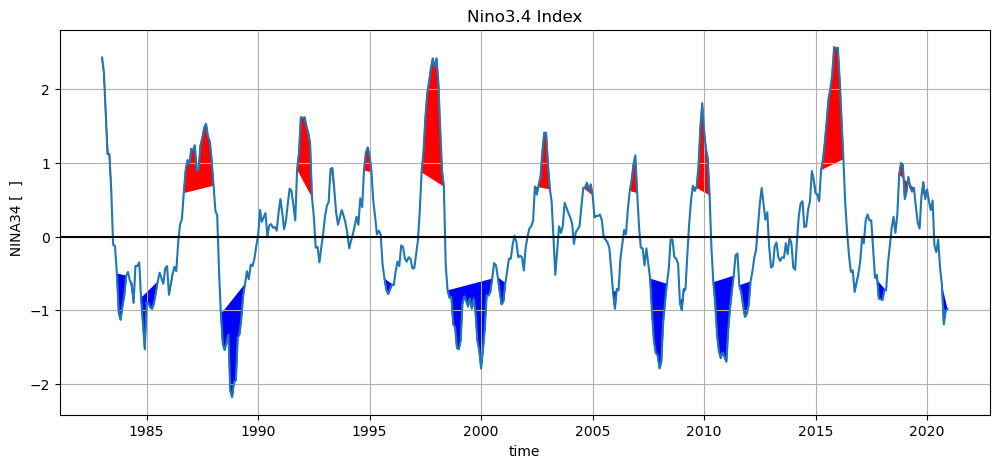

In [13]:
plt.figure(figsize=(12,5))
nino34.plot()
plt.fill(nino34.time, nino34.where(nino34>=0.5), color='r')
plt.fill(nino34.time, nino34.where(nino34<=-0.5), color='b')
plt.axhline(y=0, color='k')
plt.title('Nino3.4 Index')
plt.grid();

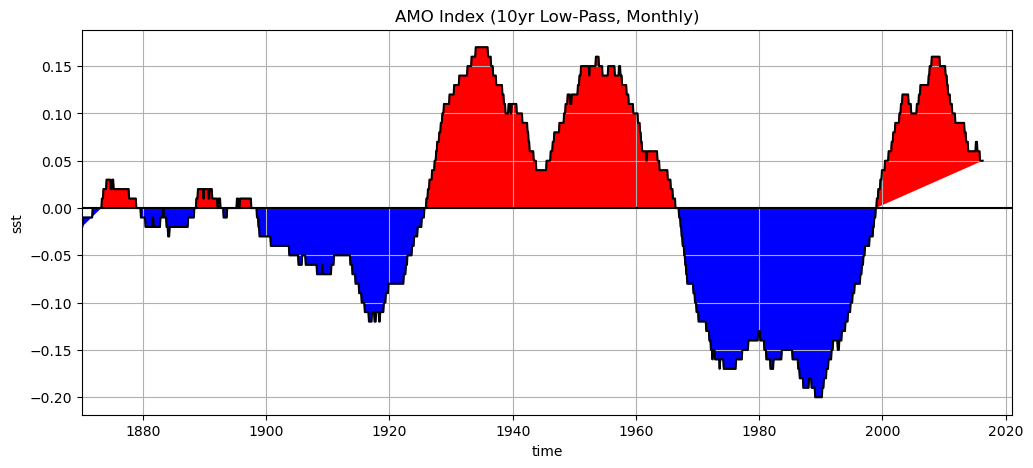

In [17]:
plt.figure(figsize=(12,5))
amo_had.plot(color='k')
plt.fill(amo_had.time, amo_had.where(amo_had>=0), color='r')
plt.fill(amo_had.time, amo_had.where(amo_had<=0), color='b')
plt.axhline(y=0, color='k')
plt.xlim(amo_had.time.sel(time='1870', method='nearest'), amo_had.time.sel(time='2021', method='nearest'))
plt.title('AMO Index (10yr Low-Pass, Monthly)')
plt.grid();

In [45]:
era_anom_dai = era.sst.groupby('time.month') - era.sst.groupby('time.month').mean('time') #daily
esm4_anom_dai = esm4_ocean.tos.groupby('time.month') - esm4_ocean.tos.groupby('time.month').mean('time') #daily
glorys_anom_dai = glorys.thetao.groupby('time.month') - glorys.thetao.groupby('time.month').mean('time') #daily

era_anom = era_anom_dai.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load() #monthly
esm4_anom = esm4_anom_dai.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load() #monthly
glorys_anom = glorys_anom_dai.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load() #monthly

amo_index = amo_had.sel(time=slice('1983', '2020')).assign_coords({'time':era_anom.time}).load() #monthly
oisst_amo = amo_oi.sel(time=slice('1983', '2020')).assign_coords({'time':era_anom.time}).load()

oisst_anom_x = oisst83.groupby('time.month') - oisst83.groupby('time.month').mean('time') #monthly
oisst_anom = oisst_anom_x.sel(time=slice(None, '2020')).assign_coords({'time':era_anom.time}).load()
hadisst_anom_x = hadisst83.groupby('time.month') - hadisst83.groupby('time.month').mean('time') #monthly
hadisst_anom = hadisst_anom_x.sel(time=slice(None, '2020')).assign_coords({'time':era_anom.time}).load()

In [58]:
had_detrend = hadisst_anom.mean(['latitude','longitude']) - trend_dict_hadisst83['sst_trend_line_lr'][:-6]
oisst_detrend = oisst_anom.mean(['lat','lon']) - trend_dict_oisst83['sst_trend_line_lr'][:-6]

era_detrended = era_anom_dai.mean(['latitude','longitude']) - trend_dict_sst_era83['sst_trend_line_lr']
esm4_detrended = esm4_anom_dai.mean(['xh','yh'])- trend_dict_sst_esm483['tos_trend_line_lr']
glorys_detrended = glorys_anom_dai.mean(['latitude','longitude']) - trend_dict_sst_glorys['thetao_trend_line_lr']

#resample to monthly
era_detrend = era_detrended.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load()
esm4_detrend = esm4_detrended.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load()
glorys_detrend = glorys_detrended.resample(time='MS').mean('time').sel(time=slice(None, '2020')).load()

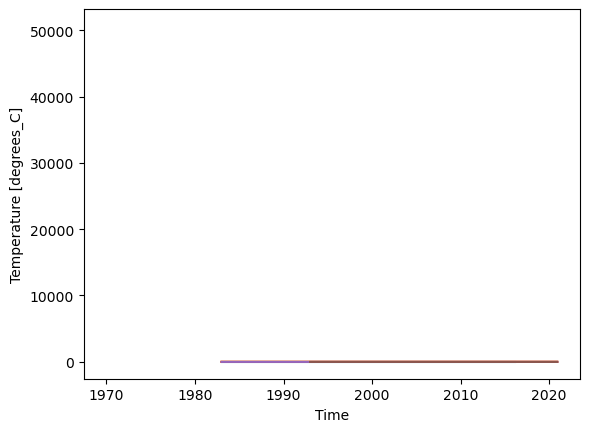

In [24]:
das = [amo_index, oisst_amo, hadisst_anom, 
       era_detrend, esm4_detrend, glorys_detrend]
das_names = ['amo index', 'oisst amo', 'hadissta', 
             'era5a', 'esm4a', 'glorysa']
plt.plot(figsize=(12,5))
for (i,j) in zip(das, das_names):
    i.plot(label=f'{j}')

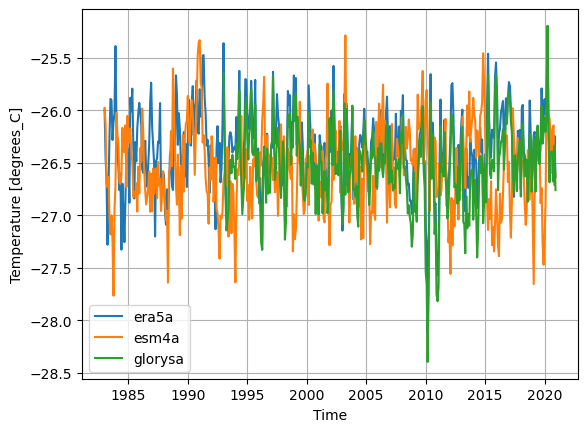

In [30]:
das = [era_detrend, esm4_detrend, glorys_detrend]
das_names = ['era5a', 'esm4a', 'glorysa']
plt.plot(figsize=(12,5))
for (i,j) in zip(das, das_names):
    i.plot(label=f'{j}')
plt.grid()
plt.legend(loc='best');

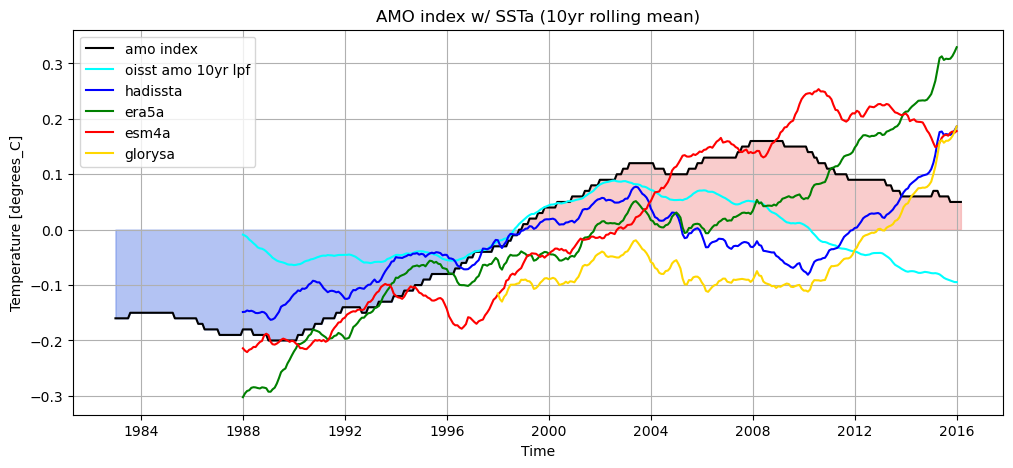

In [43]:
plt.figure(figsize=(12,5))
amo_index.plot(label='amo index', color='k')
oisst_amo.rolling(time=120, center=True).mean('time').plot(label='oisst amo 10yr lpf', color='cyan')
hadisst_anom.mean(['latitude', 'longitude']).rolling(time=120, center=True).mean('time').plot(color='blue',
                                                                                             label='hadissta')
era_anom.mean(['latitude','longitude']).rolling(time=120, center=True).mean('time').plot(color='green',
                                                                                        label='era5a')
esm4_anom.mean(['xh','yh']).rolling(time=120, center=True).mean('time').plot(color='r', 
                                                                            label='esm4a')
glorys_anom.mean(['latitude','longitude']).rolling(time=120, center=True).mean('time').plot(color='gold',
                                                                                           label='glorysa')
plt.fill_between(amo_index.time, amo_index.where(amo_index>=0), color='lightcoral', alpha=0.4)
plt.fill_between(amo_index.time, amo_index.where(amo_index<=0), color='royalblue', alpha=0.4)
plt.legend(loc='best')
plt.grid()
plt.title('AMO index w/ SSTa (10yr rolling mean)');

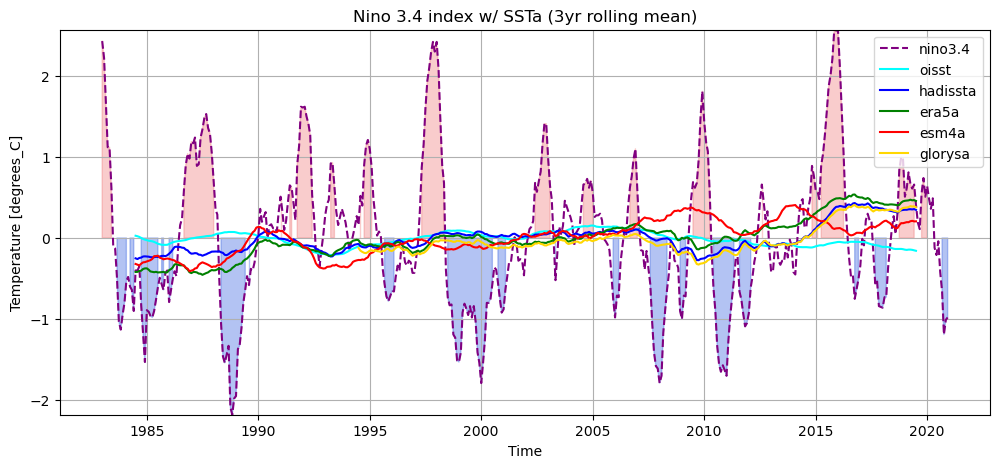

In [41]:
plt.figure(figsize=(12,5))
nino34.plot(color='purple', label='nino3.4', linestyle='dashed')
oisst_amo.rolling(time=36, center=True).mean('time').plot(label='oisst', color='cyan')
hadisst_anom.mean(['latitude', 'longitude']).rolling(time=36, center=True).mean('time').plot(color='blue',
                                                                                             label='hadissta')
era_anom.mean(['latitude','longitude']).rolling(time=36, center=True).mean('time').plot(color='green',
                                                                                        label='era5a')
esm4_anom.mean(['xh','yh']).rolling(time=36, center=True).mean('time').plot(color='r', 
                                                                            label='esm4a')
glorys_anom.mean(['latitude','longitude']).rolling(time=36, center=True).mean('time').plot(color='gold',
                                                                                           label='glorysa')
plt.fill_between(nino34.time, nino34.where(nino34>=0.5), color='lightcoral', alpha=0.4)
plt.fill_between(nino34.time, nino34.where(nino34<=-0.5), color='royalblue', alpha=0.4)
plt.ylim(nino34.min(), nino34.max())
plt.legend(loc='best')
plt.grid()
plt.title('Nino 3.4 index w/ SSTa (3yr rolling mean)');

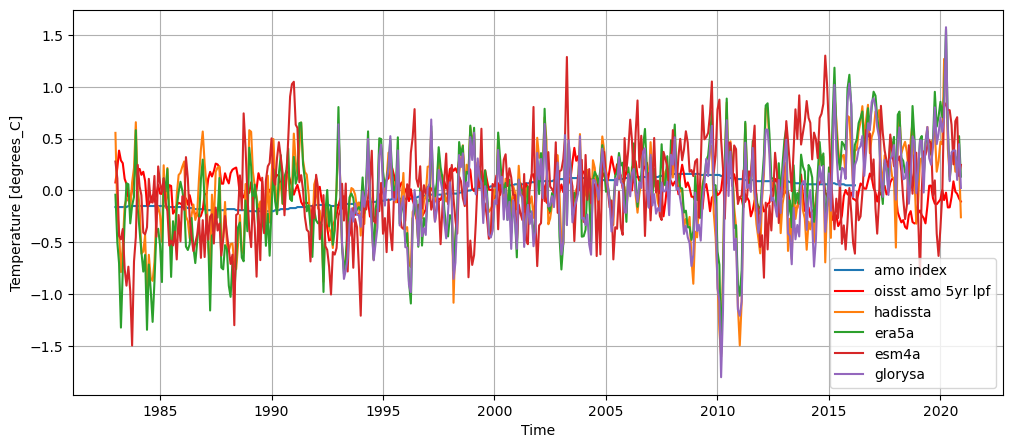

In [67]:
plt.figure(figsize=(12,5))
amo_index.plot(label='amo index')
oisst_amo.plot(label='oisst amo 5yr lpf', color='r')
hadisst_anom.mean(['latitude', 'longitude']).plot(label='hadissta')
era_anom.mean(['latitude','longitude']).plot(label='era5a')
esm4_anom.mean(['xh','yh']).plot(label='esm4a')
glorys_anom.mean(['latitude','longitude']).plot(label='glorysa')
plt.legend(loc='best')
plt.grid();

In [86]:
# AMO Indices
amo_index
oisst_amo_index = oisst_amo.rolling(time=120, center=True).mean('time')
hadisst_amo = hadisst_anom.mean(['latitude','longitude']).rolling(time=120, center=True).mean('time')
era_amo = era_anom.mean(['latitude','longitude']).rolling(time=120, center=True).mean('time')
esm4_amo = esm4_anom.mean(['xh','yh']).rolling(time=120, center=True).mean('time')
glorys_amo = glorys_anom.mean(['latitude','longitude']).rolling(time=120, center=True).mean('time')

# NINO3.4 Indices
nino34
oisst_nino = oisst_anom.rolling(time=36, center=True).mean('time')
hadisst_nino = hadisst_anom.mean(['latitude', 'longitude']).rolling(time=36, center=True).mean('time')
era_nino = era_anom.mean(['latitude','longitude']).rolling(time=36, center=True).mean('time')
esm4_nino = esm4_anom.mean(['xh','yh']).rolling(time=36, center=True).mean('time')
glorys_nino = glorys_anom.mean(['latitude','longitude']).rolling(time=36, center=True).mean('time')

In [73]:
# AMO Indices w detrended SSTs
oisst_amo_d = oisst_detrend.rolling(time=120, center=True).mean('time')
hadisst_amo_d = had_detrend.rolling(time=120, center=True).mean('time')
era_amo_d = era_detrend.rolling(time=120, center=True).mean('time')
esm4_amo_d = esm4_detrend.rolling(time=120, center=True).mean('time')
glorys_amo_d = glorys_detrend.rolling(time=120, center=True).mean('time')

# NINO3.4 Indices w detrended SSTs
oisst_nino_d = oisst_detrend.rolling(time=36, center=True).mean('time')
hadisst_nino_d = had_detrend.rolling(time=36, center=True).mean('time')
era_nino_d = era_detrend.rolling(time=36, center=True).mean('time')
esm4_nino_d = esm4_detrend.rolling(time=36, center=True).mean('time')
glorys_nino_d = glorys_detrend.rolling(time=36, center=True).mean('time')

In [88]:
#Compile ssts/indices into single ds to convert to df then to run corr heatmap
amo_indices = xr.merge([amo_index.rename('amo'), oisst_amo_index.rename('oisst'), 
                        hadisst_amo.rename('hadisst'), era_amo.rename('era'), 
                        esm4_amo.rename('esm4'), glorys_amo.rename('glorys')])
nino_indices = xr. merge([nino34.rename('nino3.4'), oisst_nino.rename('oisst'), 
                          hadisst_nino.rename('hadisst'), era_nino.rename('era'), 
                          esm4_nino.rename('esm4'), glorys_nino.rename('glorys')])
amo_ind_detrended = xr.merge([amo_index.rename('amo'), oisst_amo_index.rename('oisst'), 
                              hadisst_amo_d.rename('hadisst'), era_amo_d.rename('era'), 
                              esm4_amo_d.rename('esm4'), glorys_amo_d.rename('glorys')])
nino_ind_detrended = xr.merge([nino34.rename('nino3.4'), oisst_nino_d.rename('oisst'), 
                               hadisst_nino_d.rename('hadisst'), era_nino_d.rename('era'),
                               esm4_nino_d.rename('esm4'), glorys_nino_d.rename('glorys')])

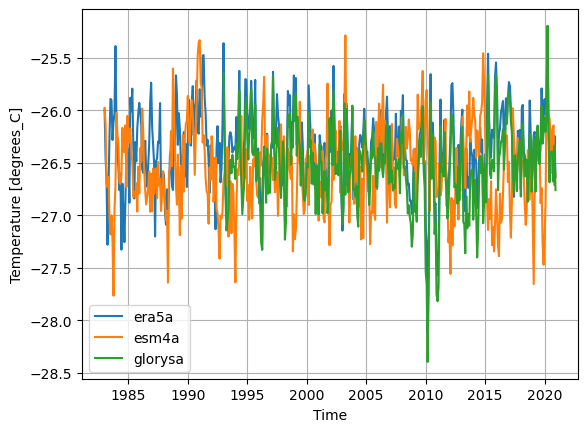

In [68]:
#amo_index.plot(label='amo index')
#oisst_amo.plot(label='oisst amo 5yr lpf', color='r')
era_detrend.plot(label='era5a')
esm4_detrend.plot(label='esm4a')
glorys_detrend.plot(label='glorysa')
plt.legend(loc='best')
plt.grid();

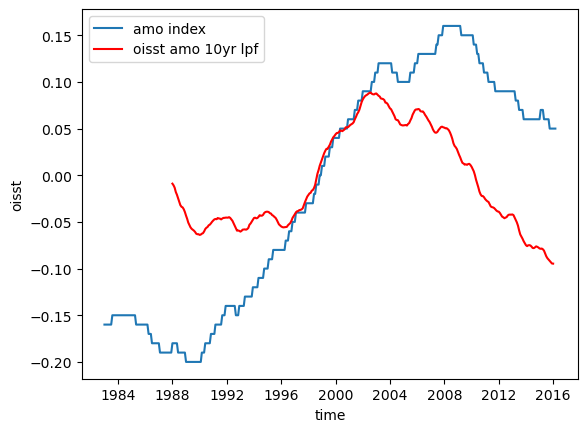

In [69]:
amo_index.plot(label='amo index')
oisst_amo_index.plot(label='oisst amo 10yr lpf', color='r')
plt.legend(loc='best')

## Correlation heat map

**INDICES to CORRELATE: `amo_indices`, `amo_ind_detrended`, `nino_indices`, `nino_ind_detrended`**

In [130]:
amo_df = amo_indices.drop_vars('month').to_dataframe()
amo_d_df = amo_ind_detrended.drop_vars('month').to_dataframe()
nino_df = nino_indices.drop_vars('month').to_dataframe()
nino_d_df = nino_ind_detrended.drop_vars('month').to_dataframe()

In [131]:
amo_df

,amo,oisst,hadisst,era,esm4,glorys
time,,,,,,
1983-01-01,-0.16,NaN,NaN,NaN,NaN,NaN
1983-02-01,-0.16,NaN,NaN,NaN,NaN,NaN
1983-03-01,-0.16,NaN,NaN,NaN,NaN,NaN
1983-04-01,-0.16,NaN,NaN,NaN,NaN,NaN
1983-05-01,-0.16,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
corr_ind_amo = amo_df.corr()
corr_ind_amo_d = amo_d_df.corr()
corr_ind_nino = nino_df.corr()
corr_ind_nino_d = nino_d_df.corr()

In [133]:
corr_ind_amo

,amo,oisst,hadisst,era,esm4,glorys
amo,1.000000,0.600665,0.640339,0.770808,0.874272,-0.219345
oisst,0.600665,1.000000,0.218141,0.030748,0.225303,-0.674049
hadisst,0.640339,0.218141,1.000000,0.842252,0.577427,0.884090
era,0.770808,0.030748,0.842252,1.000000,0.872228,0.883702
esm4,0.874272,0.225303,0.577427,0.872228,1.000000,0.315239
glorys,-0.219345,-0.674049,0.884090,0.883702,0.315239,1.000000


In [134]:
corr_ind_nino

,nino3.4,oisst,hadisst,era,esm4,glorys
nino3.4,1.000000,0.084508,0.159931,0.141776,0.015216,0.188232
oisst,0.084508,1.000000,0.802186,0.823002,0.486840,0.808919
hadisst,0.159931,0.802186,1.000000,0.871822,0.377057,0.972390
era,0.141776,0.823002,0.871822,1.000000,0.652644,0.943679
esm4,0.015216,0.486840,0.377057,0.652644,1.000000,0.107312
glorys,0.188232,0.808919,0.972390,0.943679,0.107312,1.000000


In [109]:
import seaborn as sn

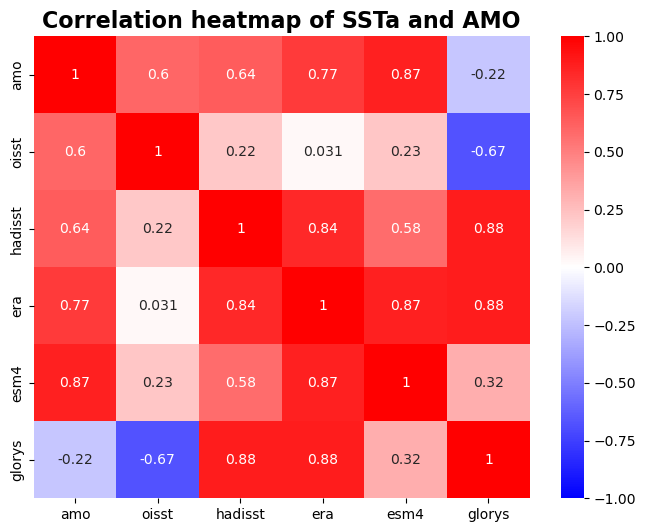

In [135]:
plt.figure(figsize=(8,6))
sn.heatmap(corr_ind_amo, annot=True, vmin=-1, vmax=1, cmap='bwr')
plt.title('Correlation heatmap of SSTa and AMO', fontsize=16, fontweight='bold')
plt.show();

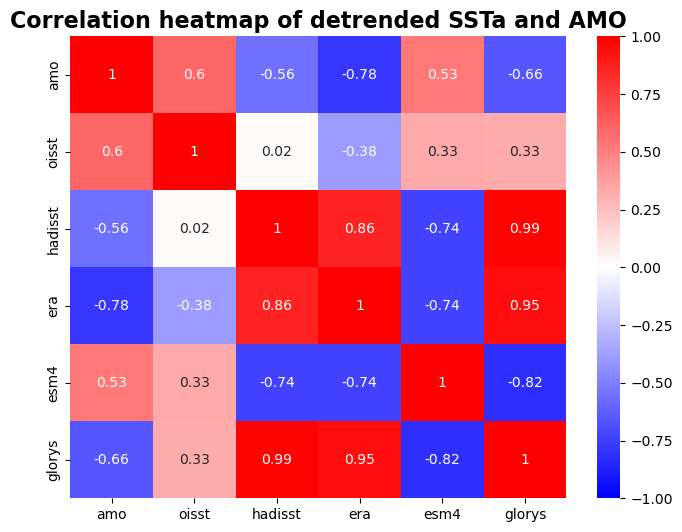

In [136]:
plt.figure(figsize=(8,6))
sn.heatmap(corr_ind_amo_d, annot=True, vmin=-1, vmax=1, cmap='bwr')
plt.title('Correlation heatmap of detrended SSTa and AMO', fontsize=16, fontweight='bold')
plt.show();

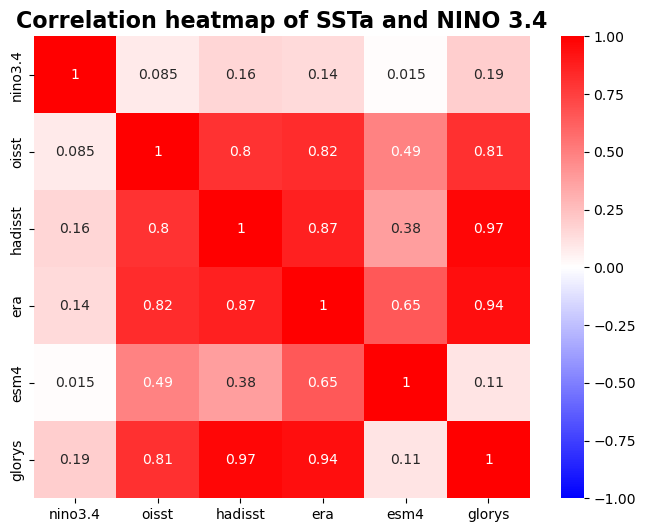

In [137]:
plt.figure(figsize=(8,6))
sn.heatmap(corr_ind_nino, annot=True, vmin=-1, vmax=1, cmap='bwr')
plt.title('Correlation heatmap of SSTa and NINO 3.4', fontsize=16, fontweight='bold')
plt.show();

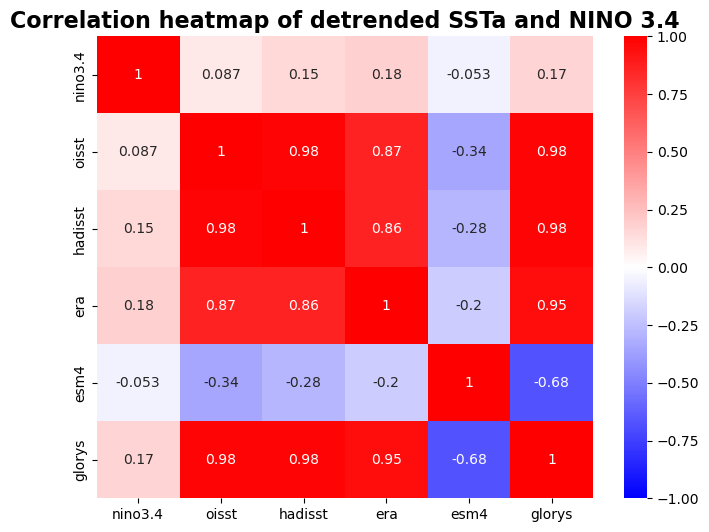

In [138]:
plt.figure(figsize=(8,6))
sn.heatmap(corr_ind_nino_d, annot=True, vmin=-1, vmax=1, cmap='bwr')
plt.title('Correlation heatmap of detrended SSTa and NINO 3.4', fontsize=16, fontweight='bold')
plt.show();